In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, random_state
from utils.utils import *
from utils.cast_data import apply_datetime_format
from src.src import *

In [4]:
# ToDos

# log transform instead of log return all cols
#     does ff_HML then remain stationary?

# need to force normal distribution?

# test features for heteroskedasticity against time?

# resolve multicolinerarity -> orthogonolisation
#     start off with highest correlation variables
    
# Regression
#     select variables
#     consider sp_cloes t-1

In [5]:
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
# df.set_index("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

df_w = cut_to_weekly_data(df_all).reset_index(drop=True).copy()

('nan format unknonw',)
('nan format unknonw',)
Unknown columns found
['date', 'date_week']


In [6]:
data_dict.update(relevant_cols=[
                    'fears35',
                    'vixo',
                    # 'naaim_std',
                    'naaim_ind',
                    'ff_M_RF',
                    'ff_SMB',
                    'ff_HML',
                    'ff_RMW',
                    'ff_CMA',
                    # 'ff_RF',
                    'termspread',
                    'pc_ratio',
                    'aaii_Bullish',
                    'sp_close'
                ])

data_dict.update(predicted="sp_close")
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [12]:
# # data papa
# _ = data_dict["relevant_cols"] + ["date"]
# cut_to_weekly_data(df_all.drop(data_dict["data_cols"]["fears"],
#                                axis=1))[[item for item in _ if item not in data_dict["data_cols"]["fears"]]].to_csv(os.path.join(OUT_DATA_DIR, "data_weekly2.csv"))
# df_w.to_csv(os.path.join(OUT_DATA_DIR, "data_weekly1.csv"))

In [6]:
# for item in data_dict["relevant_cols"]:
#     plt.figure(figsize=(5, 3))
#     plt.plot(df_w[item])
#     plt.title(item)
#     plt.show()

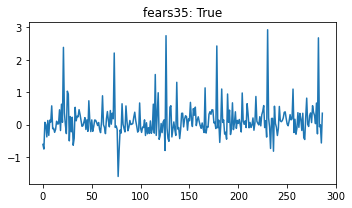

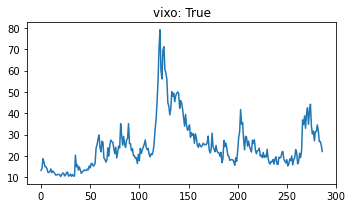

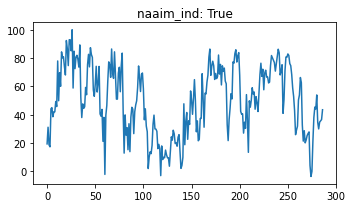

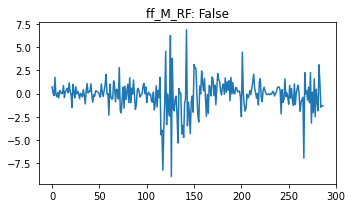

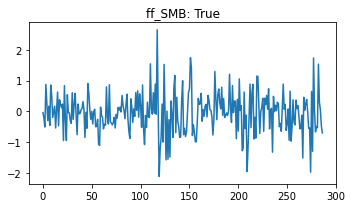

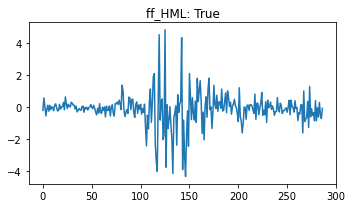

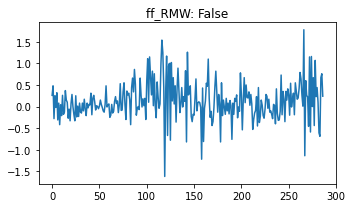

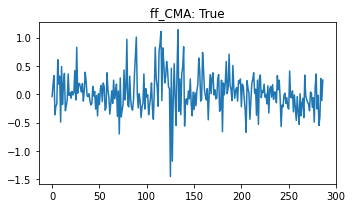

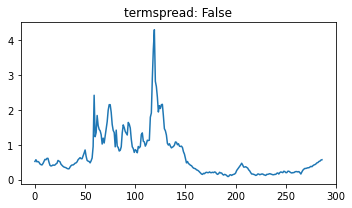

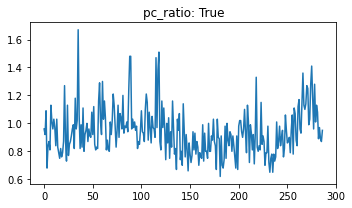

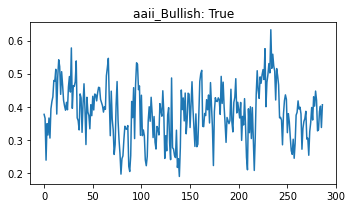

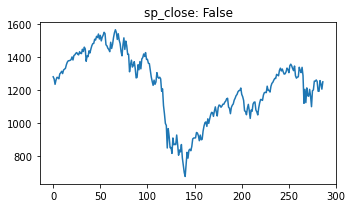

In [7]:
# stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
# normality = stest.df_test_normality(df_w, data_dict["

data_dict.update(stationarity=stationarity)

In [ ]:
def 

In [8]:
# log transform
trans = DataTransformation(df_w,
                           data_dict)

df_w = trans.get_log_returns(cols=[item for item in data_dict["relevant_cols"] if item != "ff_HML"])
data_dict = trans.df_dictionary

df_w.dropna(inplace=True)

In [9]:
# stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])

data_dict.update(stationarity=stationarity)
stationarity

{'fears35': True,
 'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True}

In [10]:
stest = StatsTest(plot=False)
normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])

data_dict.update(normality=normality)
normality

{'fears35': False,
 'vixo': False,
 'naaim_ind': False,
 'ff_M_RF': False,
 'ff_SMB': False,
 'ff_HML': False,
 'ff_RMW': False,
 'ff_CMA': False,
 'termspread': False,
 'pc_ratio': False,
 'aaii_Bullish': False,
 'sp_close': False}

In [40]:
def shift_var_relative_to_df(df_in,
                             shift_var: str,
                             new_var_name: str = None,
                             no_lags: int = -1):
    
    if no_lags > 0:
        print("Applying shifts in future")
        
    df = df_in.copy()
    if new_var_name != None:
        df[new_var_name] = df[shift_var].shift(no_lags)
    else:
        df[shift_var] = df[shift_var].shift(no_lags)
    
    return df.dropna(axis=0)

# correlation

In [78]:
df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name="sp_close_lag1")

In [79]:
cols = [
    'vixo',
    'fears35',
     'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     'pc_ratio',
     'aaii_Bullish',
    'ff_HML',
    # "sp_close_lag1"
]

In [80]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

Highest correlation of ff_HML with sp_close at -1


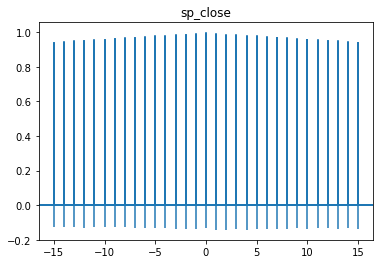

In [81]:
# lag correlation
max_lag = 15
for col in cols + [data_dict["predicted"]]:
    # plt.figure()
    x = plt.xcorr(df_ws[col], df_ws[data_dict["predicted"]], maxlags=max_lag)
    max_corr_ind = pd.DataFrame(x[1], x[0]).abs().loc[:0].sort_values(0).iloc[-1].name
    if max_corr_ind != 0:
        print(f"Highest correlation of {col} with {data_dict['predicted']} at {max_corr_ind}")
       
    plt.title(col)
    # plt.show()

In [82]:
df_ws = shift_var_relative_to_df(df_ws,
                         shift_var="ff_HML")

In [83]:
# correlation with y
df_ws[cols].corrwith(df_ws.sp_close).sort_values(ascending=False)

ff_M_RF         0.449425
aaii_Bullish    0.445014
ff_SMB          0.279664
naaim_ind       0.229646
ff_HML         -0.119684
fears35        -0.156348
ff_CMA         -0.177282
termspread     -0.177532
ff_RMW         -0.273081
pc_ratio       -0.378330
vixo           -0.625436
dtype: float64

# Multicolinerarity

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [85]:
vif = pd.DataFrame([cols,
                    [variance_inflation_factor(df_ws[cols].values, i) for i in range(df_ws[cols].shape[1])]],
                   index=["features", "VIF"]).transpose().sort_values("VIF", ascending=False)
vif.set_index("features", inplace=True)
vif = vif.join(df_ws[cols].corrwith(df_ws.sp_close).sort_values(ascending=False).rename('corr_predicted'))

In [86]:
vif

,VIF,corr_predicted
features,,
vixo,99.851147,-0.625436
termspread,85.189738,-0.177532
pc_ratio,58.638553,-0.378330
ff_CMA,48.904217,-0.177282
aaii_Bullish,42.725858,0.445014
ff_RMW,34.602032,-0.273081
fears35,33.015029,-0.156348
ff_SMB,22.7331,0.279664
ff_M_RF,20.478216,0.449425


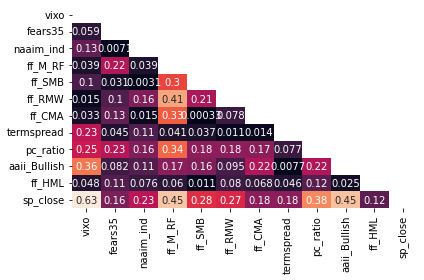

In [87]:
corr_matrix = df_ws.corr()
mask = np.triu(corr_matrix)

plt.figure()
sns.heatmap(abs(corr_matrix),
            annot=True,
            vmin=0,
            vmax=.5,
           mask=mask,
           cbar=False)
plt.tight_layout()

# Regression 2

In [88]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [89]:
df_train = shift_var_relative_to_df(df_ws,
                                    shift_var=data_dict["predicted"],
                                    no_lags=-1)

In [90]:
def tts_data(df_in, 
             y: str,
             x: list,
             add_const: bool =True):
    
    df = df_in.copy()
    y = df[y]
    X = df[x]
    if add_const == True:
        X["intercept"] = list([1] * len(X))
    
    tts = train_test_split(X, y, test_size=.3, random_state=random_state)
    
    for i, _ in enumerate(tts):
        tts[i] = tts[i].reset_index(drop=True)
        
    return tts

In [91]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols)

In [92]:
model = sm.OLS(y_train, X_train).fit()

In [93]:
model.params

vixo            0.013389
fears35         0.008663
naaim_ind       0.003838
ff_M_RF        -0.014821
ff_SMB         -0.017906
ff_RMW         -0.007757
ff_CMA          0.015926
termspread      0.016783
pc_ratio        0.001492
aaii_Bullish    0.027173
ff_HML          0.004505
intercept       0.660723
dtype: float64

In [94]:
# significance
model.pvalues < 0.05

vixo            False
fears35         False
naaim_ind       False
ff_M_RF         False
ff_SMB           True
ff_RMW          False
ff_CMA          False
termspread      False
pc_ratio        False
aaii_Bullish     True
ff_HML           True
intercept        True
dtype: bool

In [95]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               sp_close   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     3.470
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           0.000203
Time:                        22:41:26   Log-Likelihood:                 529.91
No. Observations:                 197   AIC:                            -1036.
Df Residuals:                     185   BIC:                            -996.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
vixo             0.0134      0.023      0.591      0.555      -0.031       0.058
fears35          0.0087      0.010      0.884      0.378      -0.011       0.028
naaim_ind        0.0038      0.005      0.798      0.426      -0.006       0.013
ff_M_RF         -0.0148      0.008     -1.876      0.062      -0.030       0.001
ff_SMB          -0.0179      0.009     -2.004      0.047      -0.036      -0.000
ff_RMW          -0.0078      0.011     -0.710      0.479      -0.029       0.014
ff_CMA           0.0159      0.014      1.169      0.244      -0.011       0.043
termspread       0.0168      0.015      1.112      0.268      -0.013       0.047
pc_ratio         0.0015      0.014      0.106      0.915      -0.026       0.029
aaii_Bullish     0.0272      0.013      2.023      0.045       0.001       0.054
ff_HML           0.0045      0.001      3.666      0.000       0.002       0.007
intercept        0.6607      0.030     21.929      0.000       0.601       0.720
==============================================================================
Omnibus:                       11.662   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.896
Skew:                          -0.075   Prob(JB):                     8.76e-07
Kurtosis:                       4.837   Cond. No.                         71.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
y_pred = model.predict(X_test)

In [97]:
np.mean((y_pred - y_test) ** 2)

0.00018007320955855982

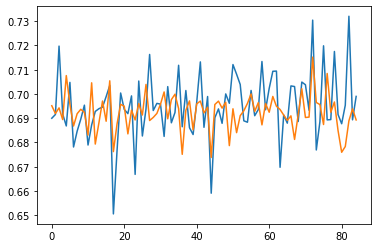

In [98]:
plt.plot(y_test)
plt.plot(y_pred)

In [99]:
res = model.resid

Errors

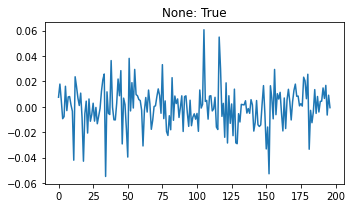

Stationarity Test Results
P-Values: 4.8925185154259606e-27
Test-stats: -14.555282193191697
Time series is stationary: True


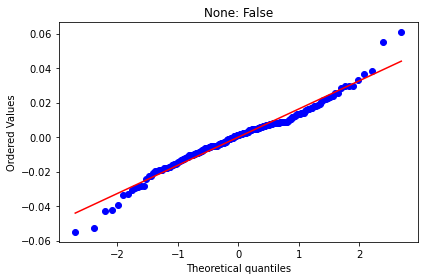

Normality Test Results
P-Values: 0.002934688241151503
Test-stats: 11.662308104833354
Series is normally distributed: False


False

In [111]:
stest = StatsTest(print_results=True)
stest.arr_stationarity_adfuller(res)
stest.arr_test_normality(res)

In [120]:
from statsmodels.stats.diagnostic import het_white
def model_heteroskedasticity_white(model,
                                   significance_level: float = 0.05,
                                   print_results: bool = True):
    
    # H0: Homoscedasticity is present (residuals are equally scattered)
    
    wtest = het_white(model.resid,  model.model.exog)
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
    test_result = dict(zip(labels, wtest))
    
    bool_result = test_result["Test Statistic p-value"] < significance_level
    if print_results == True:
        print("Test for Heteroskedasticity")
        print(f"Test p-value: {test_result['Test Statistic p-value']}")
        print(f"Heteroskedasticity is present: {bool_result}")
        
    
    return bool_result   

In [121]:
model_heteroskedasticity_white(model)

Test for Heteroskedasticity
Test p-value: 0.00037835816684534784
Heteroskedasticity is present: True


True

In [85]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

In [89]:
y = y_train.copy()
X = X_train.copy()
x = X_train.copy()

In [90]:
res = sm.OLS(y, X).fit()
# print(res.summary())

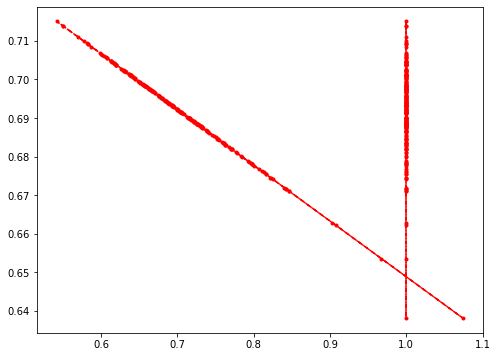

In [97]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(x, y, "o", label="data")
# ax.plot(x, y_true, "b-", label="True")
ax.plot(x, res.fittedvalues, "r--.", label="OLS")
# ax.plot(x, iv_u, "r--")
# ax.plot(x, iv_l, "r--")
# ax.legend(loc="best")

In [52]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               sp_close   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     126.7
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           2.38e-23
Time:                        18:44:20   Log-Likelihood:                 613.97
No. Observations:                 214   AIC:                            -1224.
Df Residuals:                     212   BIC:                            -1217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vixo          -0.1447      0.013    -11.257      0.000      -0.170      -0.119
constant       0.7935      0.009     87.702      0.000       0.776       0.811
==============================================================================
Omnibus:                       25.933   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.245
Skew:                          -0.158   Prob(JB):                     8.60e-29
Kurtosis:                       6.794   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([ 1.,  0.,  0.,  2.,  3.,  1.,  3.,  6., 12., 10., 21., 32., 35.,
        34., 30.,  8.,  8.,  3.,  3.,  1.,  0.,  0.,  1.]),
 array([-0.06295005, -0.05778622, -0.05262239, -0.04745856, -0.04229472,
        -0.03713089, -0.03196706, -0.02680322, -0.02163939, -0.01647556,
        -0.01131172, -0.00614789, -0.00098406,  0.00417978,  0.00934361,
         0.01450744,  0.01967128,  0.02483511,  0.02999894,  0.03516278,
         0.04032661,  0.04549044,  0.05065428,  0.05581811]),
 <BarContainer object of 23 artists>)

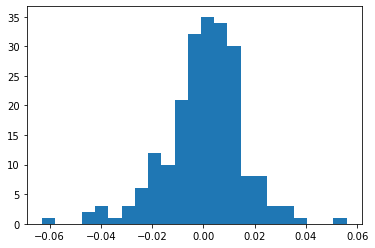

In [25]:
plt.hist(model.resid, bins="fd")

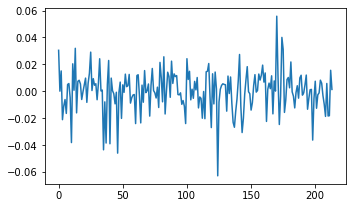

Stationarity Test Results
P-Values: 1.9128552847976596e-26
Test-stats: -14.183171911052538
Time series is stationary: True


True

In [28]:
stest = StatsTest(print_results=True)
stest.stationarity_adfuller(model.resid)
# plt.plot(model.resid)

# Regression

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ev

In [84]:
y = df_w["sp_close"]
X = df_w[cols]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state)

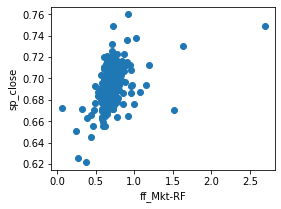

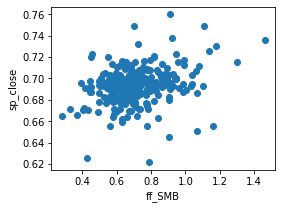

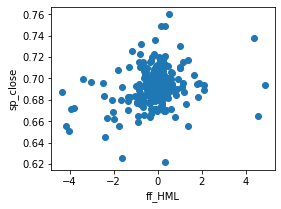

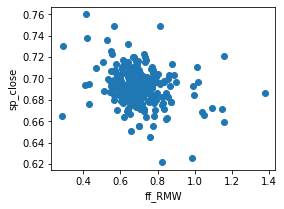

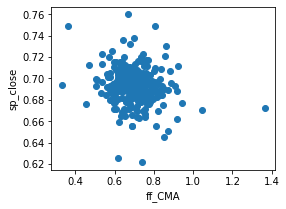

In [86]:
for col in X.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(X[col], y)
    plt.xlabel(X[col].name)
    plt.ylabel(y.name)

In [87]:
model = LinearRegression()

In [88]:
model.fit(X_train, y_train)

LinearRegression()

In [89]:
y_pred = model.predict(X_test)

In [93]:
r_sq = model.score(X_test, y_test)
r_sq

0.20794654665843548

In [90]:
resid = y_test - y_pred

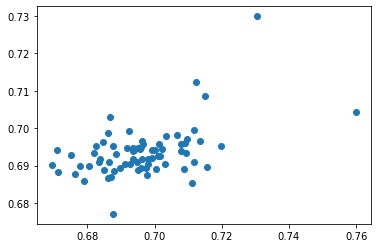

In [91]:
plt.scatter(y_test, y_pred)